In [55]:
import torch
import torch.nn.functional as F

import torchio as tio
import matplotlib.pyplot as plt

from pathlib import Path
import numpy as np


In [89]:
data_path = Path('/mnt/arbeit/simon/repo/myKeymorph/data/afids/images_acpc_sliced')
image_paths = sorted(data_path.glob('*.nii'))
subjects = []
for image_path in image_paths:
    subject = tio.Subject(
        mri=tio.ScalarImage(image_path),
        labels=tio.LabelMap(image_path.__str__().replace('images_acpc_sliced', 'labels_acpc_sliced')))
    subjects.append(subject)
# transform = tio.Compose([
#             tio.ToCanonical(), 
#             tio.RandomMotion(p=0.2),
#             tio.RandomBiasField(p=0.3),
#             tio.RandomNoise(p=0.5),
#             tio.ZNormalization(masking_method=tio.ZNormalization.mean),
#             tio.RandomAffine()
#         ])
subset = tio.SubjectsDataset(subjects)
loader = torch.utils.data.DataLoader(subset,2)

for img in loader:
    img_data = img['mri'][tio.DATA].float().squeeze(-1).transpose(-1,-2).flip([-1,-2])
    labels_data = img['labels'][tio.DATA].float().squeeze(-1).transpose(-1,-2).flip([-1,-2])
print([img_data.shape])


[torch.Size([2, 1, 256, 256])]


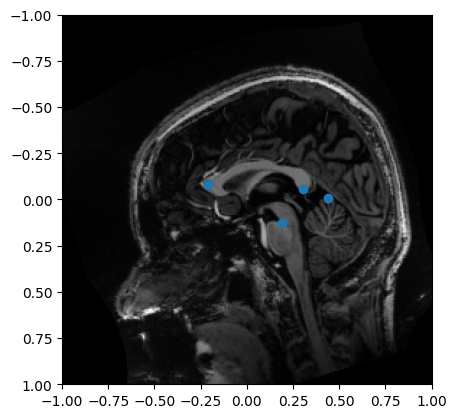

In [90]:
n_batch = labels_data.shape[0]
kp_labels = [4,10,19,20]
kp_coords = torch.zeros((n_batch, len(kp_labels), 2), dtype=torch.float32)

for i,kp_label in enumerate(kp_labels):
    b,c,y,x = torch.where(labels_data == kp_label)
    kp_coords[b, i, 0] = x.float()
    kp_coords[b, i, 1] = y.float()

kp_coords = (kp_coords - 128) / 128

b = 0
plt.imshow(img_data[b,:,:,:].squeeze().numpy(), cmap='gray', origin='upper',  extent=(-1,1,1,-1))
plt.scatter(kp_coords[b,:,0], kp_coords[b,:,1])
plt.show()

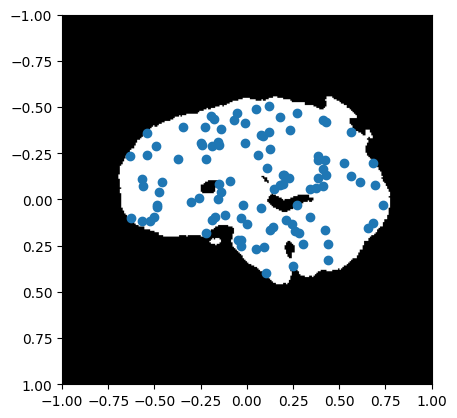

In [184]:
n_kp = 100
n_batch = mask_data.shape[0]
rand_mask_data = torch.rand(mask_data.shape) * mask_data
kp_flat_index = torch.topk(rand_mask_data.view(n_batch, -1), n_kp, dim=1)[1]
kp_coords = torch.zeros((n_batch, n_kp, 2))
for i in range(n_batch):
    c,y,x = np.unravel_index(kp_flat_index[i].numpy(), mask_data.shape[1:])
    kp_coords[i,:,0] = torch.Tensor(x)
    kp_coords[i,:,1] = torch.Tensor(y)
kp_coords = (kp_coords - 128) / 128

b = 1
plt.imshow(mask_data[b,:,:,:].squeeze().numpy(), cmap='gray', origin='upper',  extent=(-1,1,1,-1))
plt.scatter(kp_coords[b,:,0], kp_coords[b,:,1])
plt.show()